In [2]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

2022-06-09 21:04:14.004252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 21:04:14.004303: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [124]:
DATASET_PATH = f"{os.getcwd()}/dataset"

In [125]:
import librosa

In [126]:
labels = np.array(os.listdir(DATASET_PATH))
print('Labels:', labels)

Labels: ['hot' 'cool']


In [127]:
import glob

filenames = np.array(glob.glob(f"{DATASET_PATH}/*/*"))
np.random.shuffle(filenames)
num_samples = len(filenames)

print("Number of total examples:", num_samples)

for label in labels:
    print(f"Number of examples in {label}:", len(os.listdir(f"{DATASET_PATH}/{label}")))

print("Example file path:", filenames[0])

Number of total examples: 414
Number of examples in hot: 231
Number of examples in cool: 183
Example file path: /home/i_am_v/tinyml/sound-termometer/sound_termometer/dataset/hot/hot-46.wav


In [128]:
border_1 = int(num_samples * 0.8)
border_2 = (num_samples - border_1) // 2
train_files = filenames[:border_1]
val_files = filenames[border_1:-border_2]
test_files = filenames[-border_2:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 331
Validation set size 42
Test set size 41


In [129]:
def get_label(file_path):
    file_path = file_path.decode()
    tmp = file_path.split(f'{DATASET_PATH}')[1]
    return tmp.split('/')[1]
    
def decode_audio(file_path):
    wav_audio, wav_sample_rate = librosa.load(file_path)
    return wav_audio
    
def get_waveform_and_label(file_paths):
    for file_path in file_paths:
        wav_label = get_label(file_path)
        waveform = decode_audio(file_path)
        yield waveform, wav_label

In [130]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        np.array([16000]) - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' data type to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spec = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spec = tf.abs(spec)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`)).
    spec = spec[..., tf.newaxis]
    return spec

def get_spectrogram_and_label_id(wav, wav_label):
    spec= get_spectrogram(wav)
    label_id = tf.argmax(wav_label == labels)
    return spec, label_id

In [131]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_dataset(files):
    output_ds = tf.data.Dataset.from_generator(get_waveform_and_label,
                                          args=[files],
                                          output_shapes=((None,), ()),
                                          output_types=(np.float32, np.str_))
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [132]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [133]:
spectrogram, label_index = None, None

for train_spec, label in train_ds.take(1):
    label_index = np.array(label)
    spectrogram = np.array(train_spec)

if spectrogram.any() and label_index.any():
    print('Label:', labels[label_index])
    print('Spectrogram shape:', spectrogram.shape)

In [134]:
def plot_spectrogram(spec, ax):
    if len(spec.shape) > 2:
        assert len(spec.shape) == 3
        spec = np.squeeze(spec, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spec.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    x = np.linspace(0, np.size(spec), num=width, dtype=int)
    y = range(height)
    ax.pcolormesh(x, y, log_spec)

In [135]:
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import Input
from keras.layers import Resizing


model = tf.keras.Sequential([
    Input(shape=(124, 129, 1)),
    # Down sample the input.
    Resizing(32, 32),
    
    Conv2D(16, kernel_size=(2, 2), padding='same',activation='relu'),
    MaxPooling2D(),
    
    Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Dropout(0.2),
    Flatten(),
    
    Dense(128),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 16)        80        
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        2080      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 64)         

In [136]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [137]:
train_ds = train_ds.batch(16)
val_ds = val_ds.batch(16)

In [138]:
for image_batch, label_batch in train_ds.take(1).as_numpy_iterator():
    print(image_batch.shape)
    print(label_batch.shape)
    break

(16, 124, 129, 1)
(16,)


In [139]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [140]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [147]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/15
21/21 [==============================] - 6s 303ms/step - loss: 0.6112 - accuracy: 0.6405 - val_loss: 0.7717 - val_accuracy: 0.5714
Epoch 2/15
21/21 [==============================] - 6s 290ms/step - loss: 0.5879 - accuracy: 0.6526 - val_loss: 0.7472 - val_accuracy: 0.5714
Epoch 3/15
21/21 [==============================] - 6s 286ms/step - loss: 0.5571 - accuracy: 0.7130 - val_loss: 0.7398 - val_accuracy: 0.5952
Epoch 4/15
21/21 [==============================] - 6s 289ms/step - loss: 0.5288 - accuracy: 0.7130 - val_loss: 0.7271 - val_accuracy: 0.5714
Epoch 5/15
21/21 [==============================] - 6s 289ms/step - loss: 0.5105 - accuracy: 0.7341 - val_loss: 0.7178 - val_accuracy: 0.6190
Epoch 6/15
21/21 [==============================] - 6s 287ms/step - loss: 0.4602 - accuracy: 0.7915 - val_loss: 0.6796 - val_accuracy: 0.5714
Epoch 7/15
21/21 [==============================] - 6s 289ms/step - loss: 0.4125 - accuracy: 0.8097 - val_loss: 0.7573 - val_accuracy: 0.5714
Epoch 

In [148]:
model.save("models/water_model")

2022-04-13 01:11:23.763362: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/water_model/assets


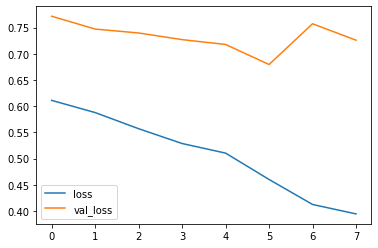

In [149]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

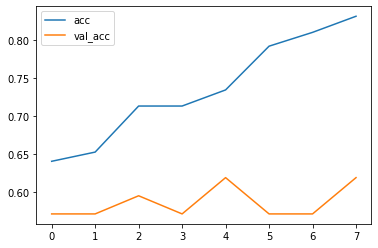

In [150]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [151]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [152]:
from sklearn.metrics import accuracy_score

y_predict = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels
test_acc = accuracy_score(y_true, y_predict)

print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 85%


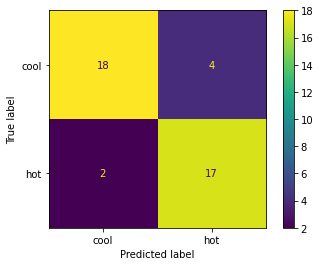

In [153]:
from sklearn.metrics import ConfusionMatrixDisplay

conf = ConfusionMatrixDisplay(
    np.array(tf.math.confusion_matrix(y_true, y_predict, num_classes=2)),
    display_labels=np.array(['cool', 'hot'])).plot()

plt.show()